# Анализ пиков гистоновой метки

Анализ проводился для гистоновой метки **H3F3A** версии генома **hg19**

Biosample summary: Homo sapiens smooth muscle cell originated from H9

#### Скачиваем и распаковываем датасеты

In [1]:
!wget https://www.encodeproject.org/files/ENCFF892BZE/@@download/ENCFF892BZE.bed.gz -P ./data
!wget https://www.encodeproject.org/files/ENCFF925KAE/@@download/ENCFF925KAE.bed.gz -P ./data

In [2]:
!zcat < ./data/ENCFF892BZE.bed.gz  |  cut -f1-5 > ./data/H3F3A.ENCFF892BZE.hg19.bed
!zcat < ./data/ENCFF925KAE.bed.gz  |  cut -f1-5 > ./data/H3F3A.ENCFF925KAE.hg19.bed

#### Импортируем все необходимые библиотеки
Для наглядности и удобства экспериментов использовалась библиотека **rpy2**, которая позволяет запускать скрипты, написанные на R внутри скриптов Python 

In [3]:
import os
import pandas as pd
import numpy as np

from plotnine import *
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.image as img

import warnings
warnings.filterwarnings('ignore')

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr

#### Указываем расположение всех данных, которые будут использоваться в анализе

In [4]:
SOURCE_BED_FILE1 = 'H3F3A.ENCFF892BZE.hg19'
SOURCE_BED_FILE2 = 'H3F3A.ENCFF925KAE.hg19'

FILTERED_BED_FILE1 = 'H3F3A.ENCFF892BZE.hg19.filtered'
FILTERED_BED_FILE2 = 'H3F3A.ENCFF925KAE.hg19.filtered'

DATA_DIR_NAME = '/Users/a_nugmanova/work/hse_bio/data/'
IMAGES_DIR_NAME = '/Users/a_nugmanova/work/hse_bio/images/'

DEEPZ_BED_FILE = 'DeepZ'
INTERSECT_BED_FILE = 'H3F3A.ENCSR672HBY.intersect_with_DeepZ'

#### Загружаем данные

In [5]:
header = ['chrom', 'chromStart', 'chromEnd', 'name', 'score']

df1 = pd.read_csv(os.path.join(DATA_DIR_NAME, SOURCE_BED_FILE1 + '.bed'), \
                             sep='\t', comment='t', header=None)
df2 = pd.read_csv(os.path.join(DATA_DIR_NAME, SOURCE_BED_FILE2 + '.bed'), \
                             sep='\t', comment='t', header=None)

df1.columns = header[:len(df1.columns)]
df2.columns = header[:len(df1.columns)]

In [6]:
df1['length'] = df1['chromEnd'] - df1['chromStart']
df2['length'] = df2['chromEnd'] - df2['chromStart']

#### Строим гистограммы длин

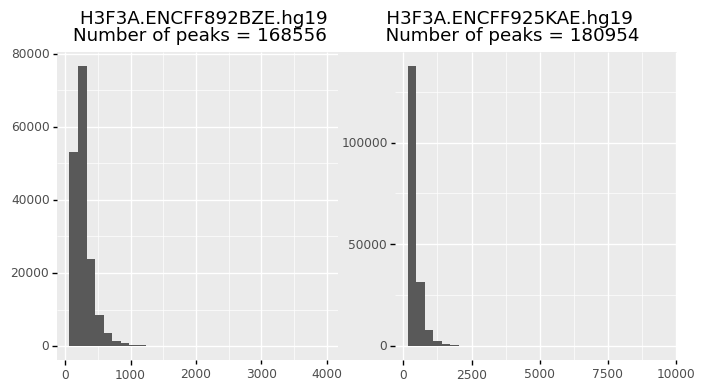

In [7]:
p1 = (ggplot(df1, aes(x='length'))+geom_histogram() + stat_bin(bins=30) \
      + ggtitle(SOURCE_BED_FILE1 + '\nNumber of peaks = %s'%df1.shape[0]))
p2 = (ggplot(df2, aes(x='length'))+geom_histogram() + stat_bin(bins=30) \
      + ggtitle(SOURCE_BED_FILE1 + '\nNumber of peaks = %s'%df2.shape[0]))

plots = {SOURCE_BED_FILE1: p1, SOURCE_BED_FILE2: p2}

gap = '          '
fig = (ggplot() + geom_histogram() + stat_bin(bins=30) + theme(figure_size=(8, 4)) + labs(x="", y="") \
       + ggtitle(SOURCE_BED_FILE1 + gap + SOURCE_BED_FILE2 + '\n' \
       + 'Number of peaks = %s'%df1.shape[0] + gap + 'Number of peaks = %s'%df2.shape[0])).draw()

for i, image_name in enumerate(plots.keys()):  
    ax = fig.add_subplot(1,2,i+1)
    plots[image_name]._draw_using_figure(fig, [ax])
    
    plots[image_name].save(os.path.join(IMAGES_DIR_NAME, image_name + '.png'), dpi=500, verbose=False)


#### Фильтрация пиков 
##### Для фильтрации были выбраны пороги 824 и 1349 соответственно, поскольку 99% длин имеют меньшее значение 

In [8]:
border = np.quantile(df1['length'], q = 0.99)
filtered_df1 = df1.loc[(df1['length'] <= border)].reset_index(drop=True)

border = np.quantile(df2['length'], q = 0.99)
filtered_df2 = df2.loc[(df2['length'] <= border)].reset_index(drop=True)

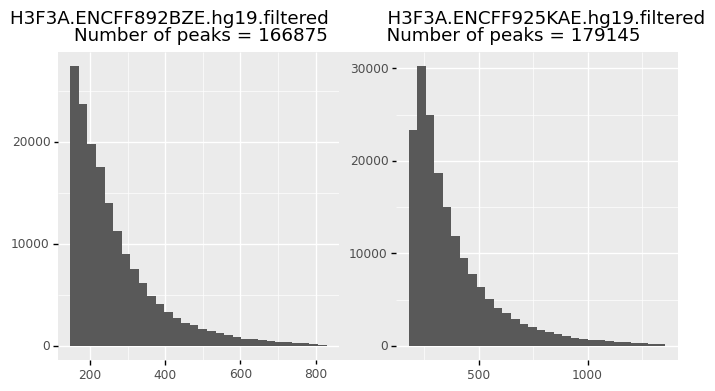

In [9]:
p1 = (ggplot(filtered_df1, aes(x='length'))+geom_histogram() + stat_bin(bins=30) \
      + ggtitle(FILTERED_BED_FILE1 + '\nNumber of peaks = %s'%filtered_df1.shape[0]))
p2 = (ggplot(filtered_df2, aes(x='length'))+geom_histogram() + stat_bin(bins=30) \
      + ggtitle(FILTERED_BED_FILE2 + '\nNumber of peaks = %s'%filtered_df2.shape[0]))

plots = {FILTERED_BED_FILE1: p1, FILTERED_BED_FILE2: p2}

gap = '          '
fig = (ggplot() + geom_histogram() + stat_bin(bins=30) + theme(figure_size=(8, 4)) + labs(x="", y="") \
       + ggtitle(FILTERED_BED_FILE1 + gap + FILTERED_BED_FILE2 + '\n' \
       + 'Number of peaks = %s'%filtered_df1.shape[0] + gap + 'Number of peaks = %s'%filtered_df2.shape[0])).draw()

for i, image_name in enumerate(plots.keys()):  
    ax = fig.add_subplot(1,2,i+1)
    plots[image_name]._draw_using_figure(fig, [ax])
    
    plots[image_name].save(os.path.join(IMAGES_DIR_NAME, image_name + '.png'), dpi=500, verbose=False)


#### Сохраняем полученные отфильтрованные данные 

In [10]:
filtered_df1.to_csv(os.path.join(DATA_DIR_NAME, FILTERED_BED_FILE1 + '.bed'), \
                    columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score'], \
                    sep='\t', index=False, header=False)
filtered_df2.to_csv(os.path.join(DATA_DIR_NAME, FILTERED_BED_FILE2 + '.bed'), \
                    columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score'], \
                    sep='\t', index=False, header=False)

#### Строим гистограмму расположения пиков относительно аннотированных генов

In [11]:
R_function = '''
        library(ChIPpeakAnno)
        library(ChIPseeker)
        library(TxDb.Hsapiens.UCSC.hg19.knownGene)
        library(org.Hs.eg.db)

        txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
        
        DATA_DIR <- "%s"
        FILE_NAME <- "%s"
        OUT_DIR <- "%s"
        
        peaks <- toGRanges(paste0(DATA_DIR, FILE_NAME, '.bed'), format="BED")
        
        peakAnno <- annotatePeak(peaks, tssRegion=c(-3000, 3000), TxDb=txdb, annoDb="org.Hs.eg.db")
        
        png(paste0(OUT_DIR, FILE_NAME, '.plotAnnoPie.png'))
        
        plotAnnoPie(peakAnno)
        dev.off()
'''

In [14]:
robjects.r(R_function % (DATA_DIR_NAME, FILTERED_BED_FILE1, IMAGES_DIR_NAME))
robjects.r(R_function % (DATA_DIR_NAME, FILTERED_BED_FILE2, IMAGES_DIR_NAME))

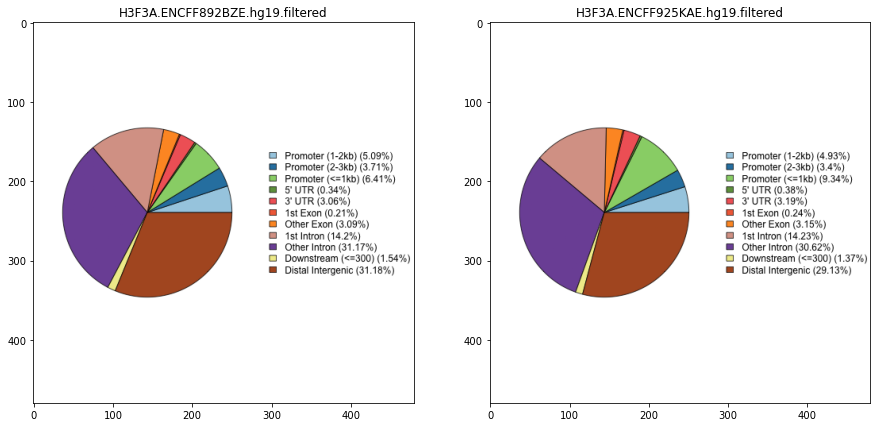

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

for i, file_name in enumerate([FILTERED_BED_FILE1, FILTERED_BED_FILE2]):
    AnnoPie = img.imread(os.path.join(IMAGES_DIR_NAME, file_name + '.plotAnnoPie.png'))
    axs[i].imshow(AnnoPie)
    axs[i].set_title(file_name)


#### Объединяем два набора отфильтрованных ChIP-seq пиков

In [16]:
!cat  ./data/*.filtered.bed  |   sort -k1,1 -k2,2n   |   bedtools merge   >  ./data/H3F3A.ENCSR672HBY.merge.hg19.bed 

#### Визуализация данных в Genome Browser

track visibility=dense name="ENCFF892BZE"  description="H3F3A.ENCFF892BZE.hg19.filtered.bed"
https://raw.githubusercontent.com/ANugmanova/hse21_H3F3A_ZDNA_human/experiments/data/H3F3A.ENCFF892BZE.hg19.filtered.bed

track visibility=dense name="ENCFF925KAE"  description="H3F3A.ENCFF925KAE.hg19.filtered.bed"
https://raw.githubusercontent.com/ANugmanova/hse21_H3F3A_ZDNA_human/experiments/data/H3F3A.ENCFF925KAE.hg19.filtered.bed
    
track visibility=dense name="ChIP_merge"  color=50,50,200    description="H3F3A.ENCSR672HBY.merge.hg19.bed"
https://raw.githubusercontent.com/ANugmanova/hse21_H3F3A_ZDNA_human/experiments/data/H3F3A.ENCSR672HBY.merge.hg19.bed


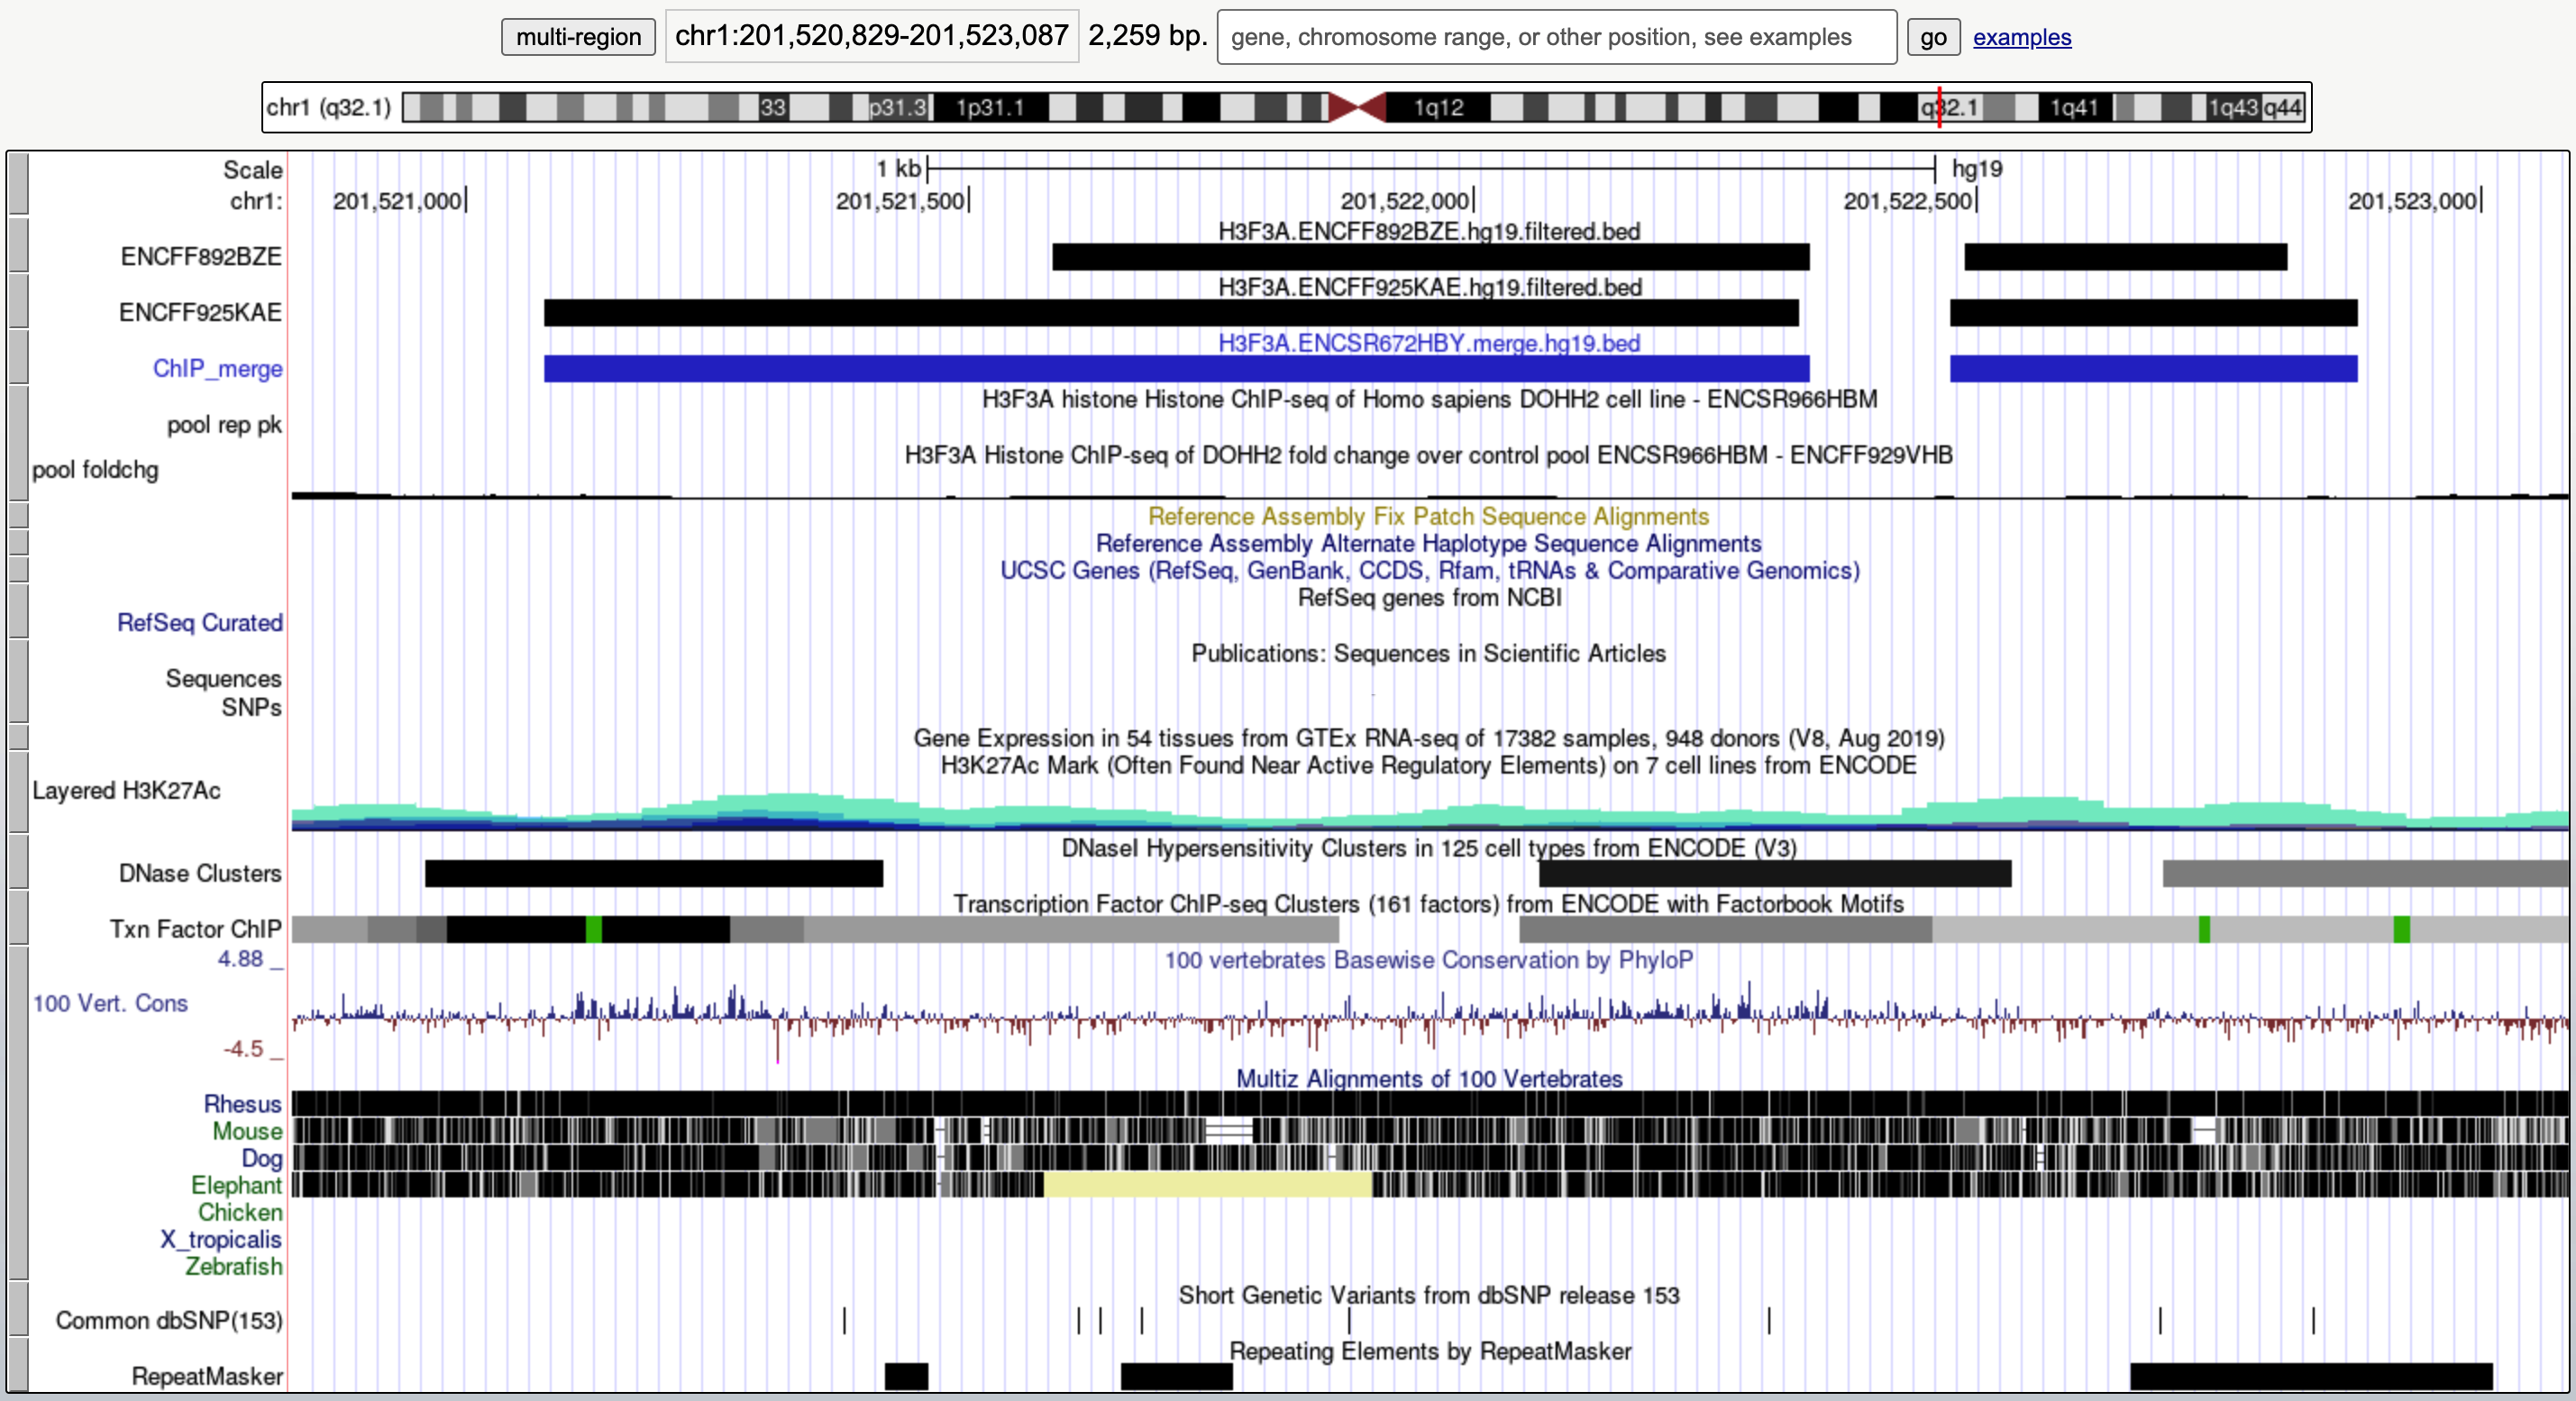

# Анализ участков вторичной структуры ДНК

#### Загружаем разметку

In [17]:
header = ['chrom', 'chromStart', 'chromEnd',]

deepz_df = pd.read_csv(os.path.join(DATA_DIR_NAME, DEEPZ_BED_FILE + '.bed'), \
                             sep='\t', comment='t', header=None)

deepz_df.columns = header[:len(deepz_df.columns)]
deepz_df['length'] = deepz_df['chromEnd'] - deepz_df['chromStart']

#### Строим гистограмму длин

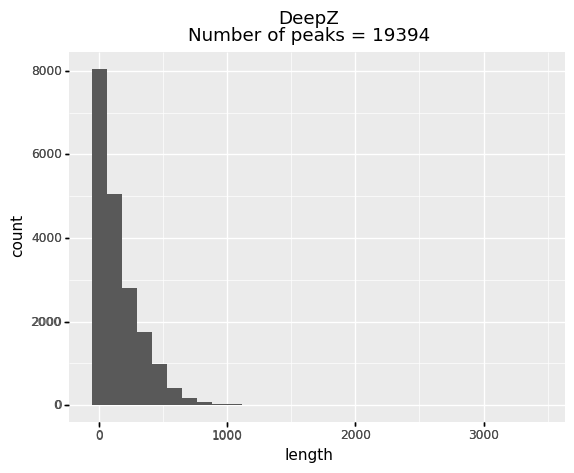

In [18]:
p = (ggplot(deepz_df, aes(x='length'))+geom_histogram() + stat_bin(bins=30) \
      + ggtitle(DEEPZ_BED_FILE + '\nNumber of peaks = %s'%deepz_df.shape[0]))

fig = p.draw()
ax = fig.add_subplot()
p._draw_using_figure(fig, [ax])
    
p.save(os.path.join(IMAGES_DIR_NAME, DEEPZ_BED_FILE + '.png'), dpi=500, verbose=False)


In [20]:
robjects.r(R_function % (DATA_DIR_NAME, DEEPZ_BED_FILE, IMAGES_DIR_NAME))

Text(0.5, 1.0, 'H3F3A.ENCFF925KAE.hg19.filtered')

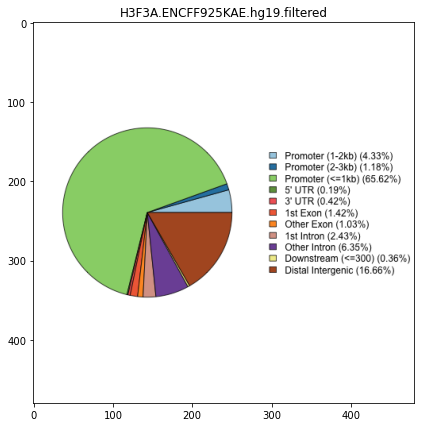

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

AnnoPie = img.imread(os.path.join(IMAGES_DIR_NAME, DEEPZ_BED_FILE + '.plotAnnoPie.png'))
ax.imshow(AnnoPie)
ax.set_title(file_name)

# Анализ пересечений гистоновой метки и структуры ДНК

#### Находим пересечения


In [22]:
!bedtools intersect -a data/DeepZ.bed -b data/H3F3A.ENCSR672HBY.merge.hg19.bed > data/H3F3A.ENCSR672HBY.intersect_with_DeepZ.bed

#### Загружаем пересечения


In [23]:
header = ['chrom', 'chromStart', 'chromEnd',]

intersect_df = pd.read_csv(os.path.join(DATA_DIR_NAME, INTERSECT_BED_FILE + '.bed'), \
                             sep='\t', comment='t', header=None)

intersect_df.columns = header[:len(intersect_df.columns)]
intersect_df['length'] = intersect_df['chromEnd'] - intersect_df['chromStart']

#### Строим гистограмму длинн

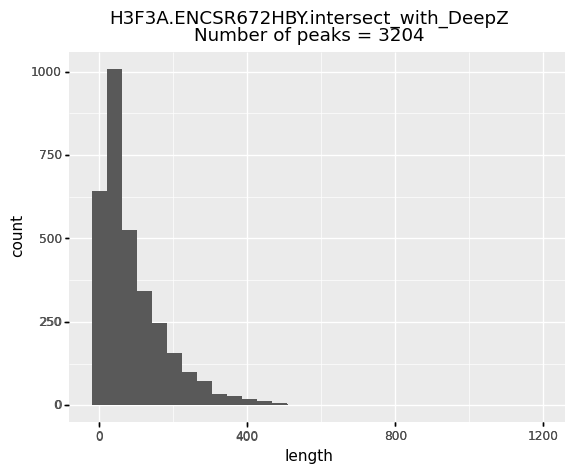

In [24]:
p = (ggplot(intersect_df, aes(x='length'))+geom_histogram() + stat_bin(bins=30) \
      + ggtitle(INTERSECT_BED_FILE + '\nNumber of peaks = %s'%intersect_df.shape[0]))

fig = p.draw()
ax = fig.add_subplot()
p._draw_using_figure(fig, [ax])
    
p.save(os.path.join(IMAGES_DIR_NAME, INTERSECT_BED_FILE + '.png'), dpi=500, verbose=False)

Общая доля пересекающихся с DeepZ пиков среди всех пиков из эксперимента: *0.0115*

#### Визуализируем участки с помощью Genome Browser

Ссылка на сессию http://genome.ucsc.edu/s/aigul/hg19

Насколько я понимаю, у меня получилось, что пересечения есть на всем участке *chr1:10.089-10.592*

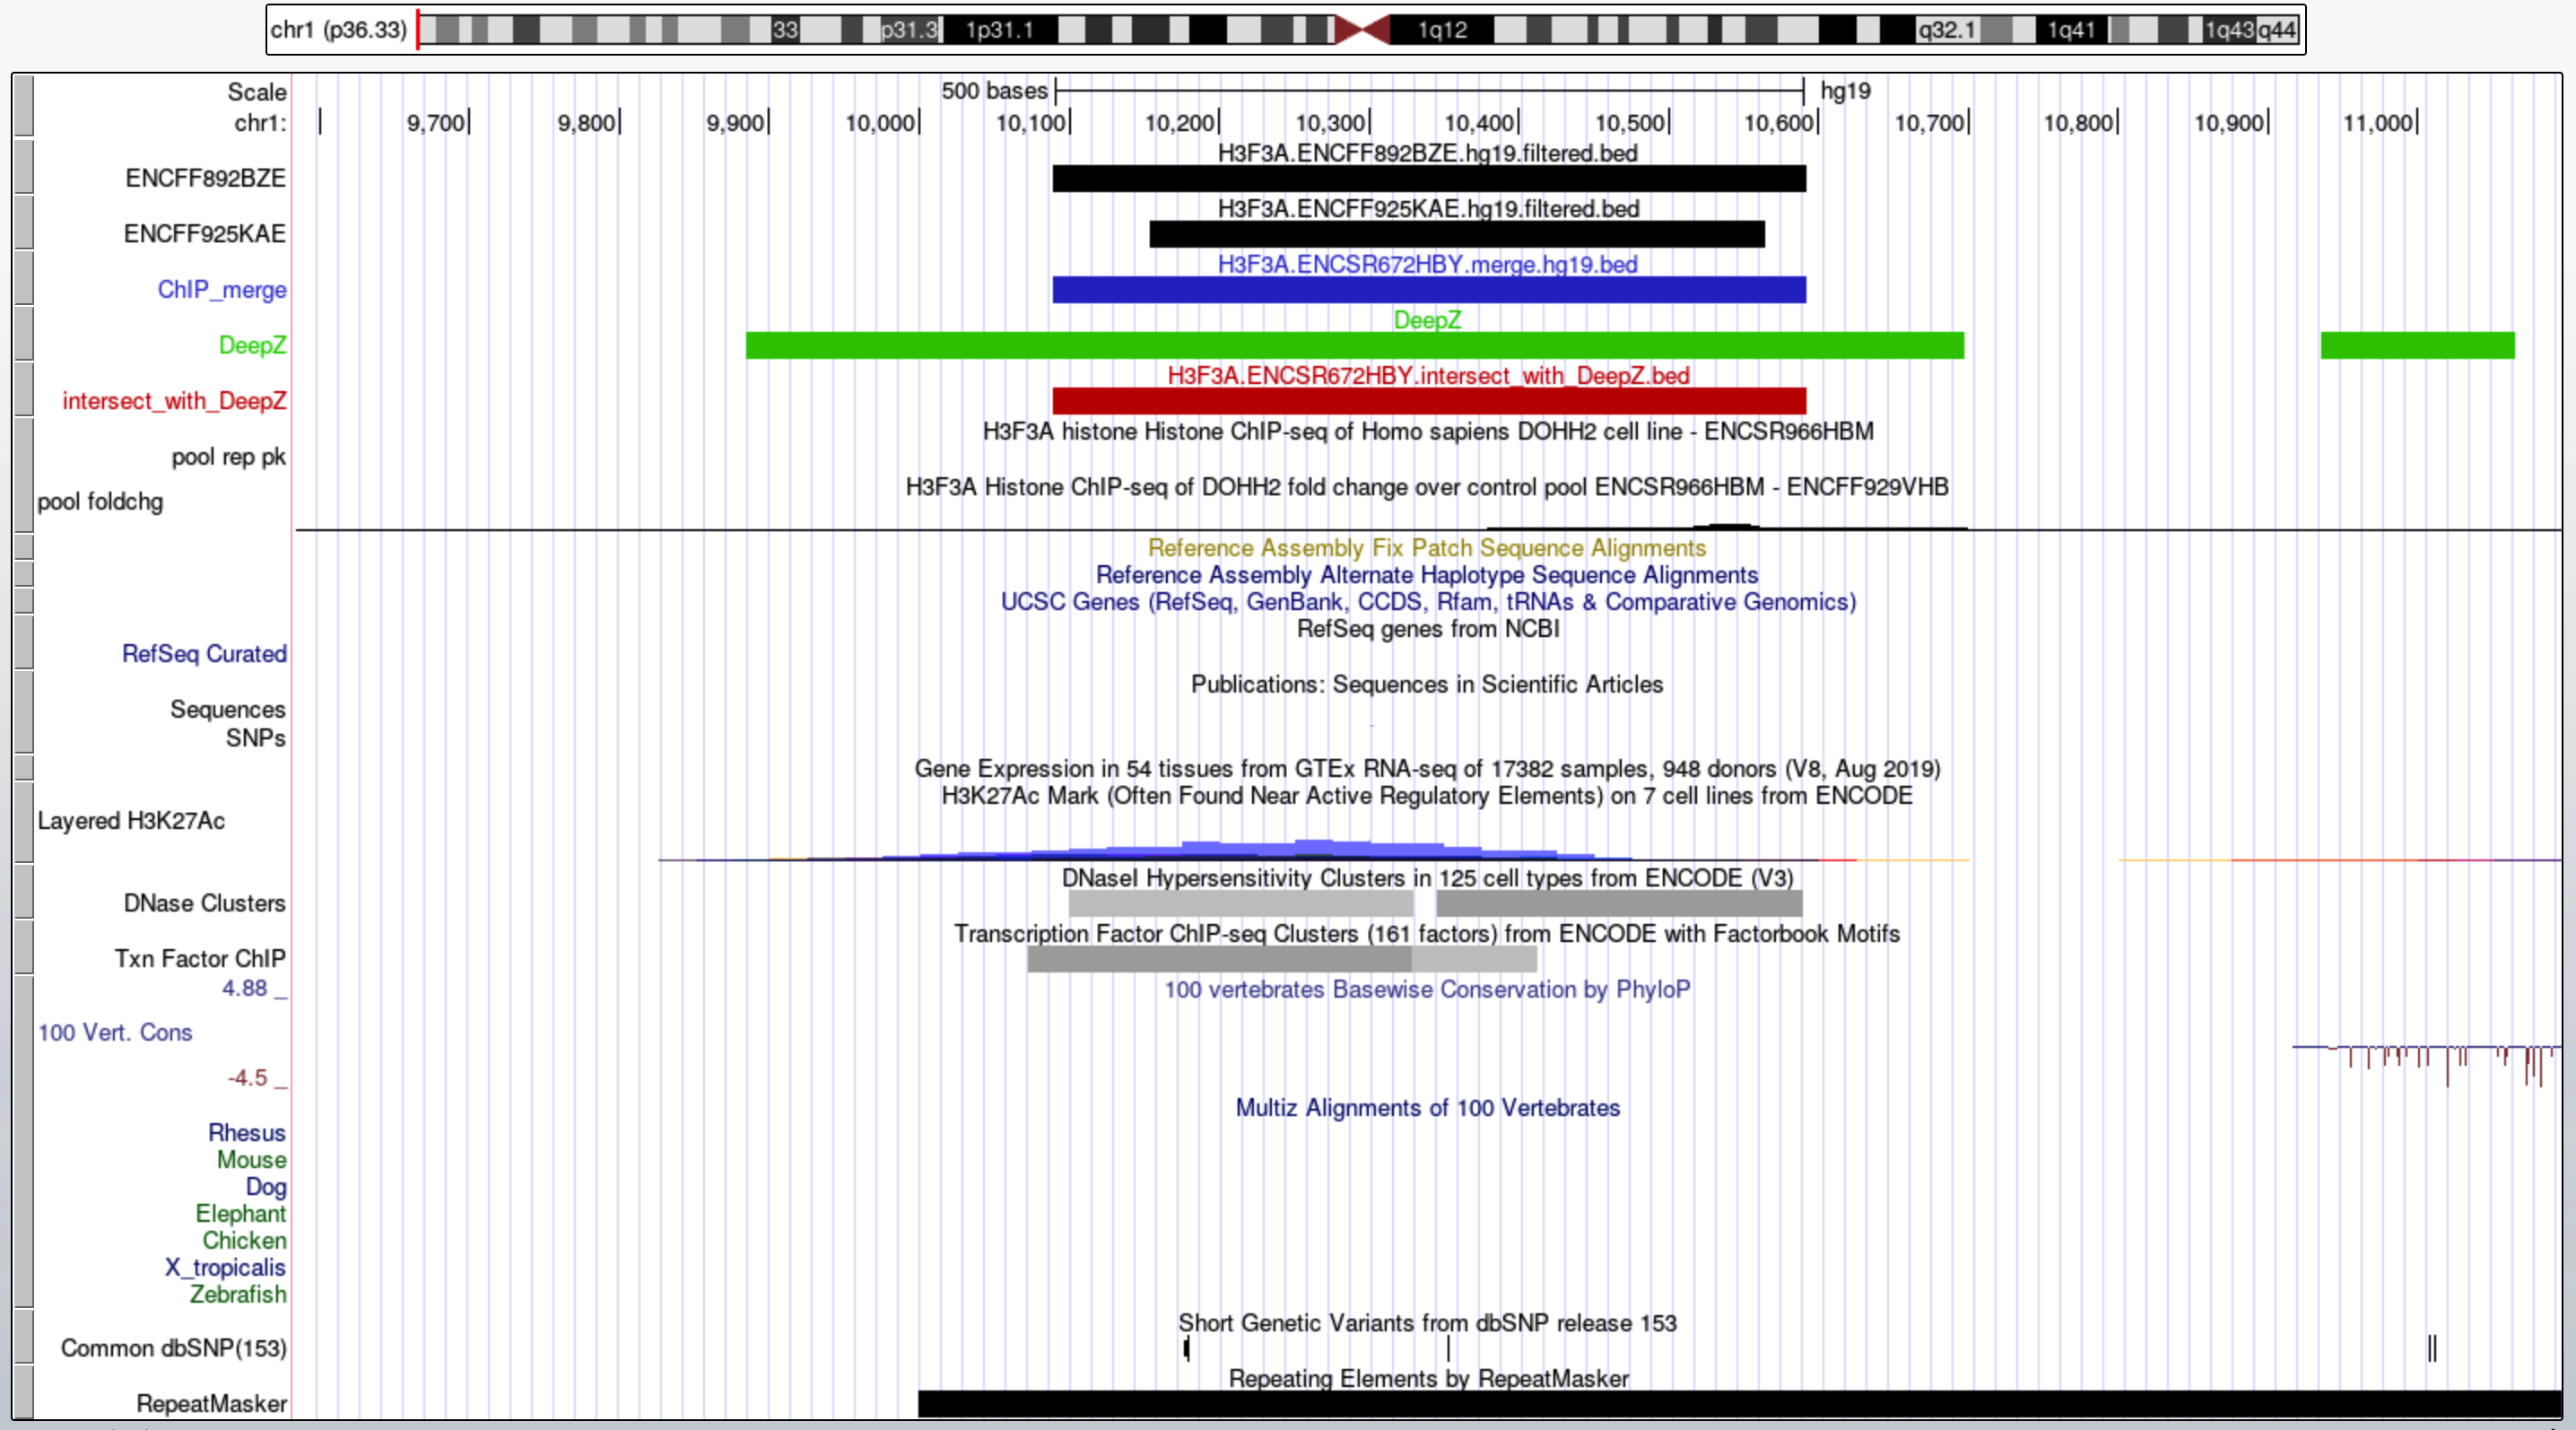

#### Ассоциируем полученные пересечения с ближайшими генами

In [25]:
robjects.r('''
        library(ChIPpeakAnno)
        library(TxDb.Hsapiens.UCSC.hg19.knownGene)
        library(org.Hs.eg.db)
        library(magrittr)

        DATA_DIR <- '/Users/a_nugmanova/work/hse_bio/data/'
        FILE_NAME <- 'H3F3A.ENCSR672HBY.intersect_with_DeepZ'
        
        peaks <- toGRanges(paste0(DATA_DIR, FILE_NAME, '.bed'), format="BED")
        peaks[1:2]

        annoData <- toGRanges(TxDb.Hsapiens.UCSC.hg19.knownGene)
        annoData[1:2]


        anno <- annotatePeakInBatch(peaks, AnnotationData=annoData, 
                                    output="overlapping", 
                                    FeatureLocForDistance="TSS",
                                    bindingRegion=c(-2000, 300))
        data.frame(anno) %>% head()

        anno$symbol <- xget(anno$feature, org.Hs.egSYMBOL)
        data.frame(anno) %>% head()

        anno_df <- data.frame(anno)
        write.table(anno_df, file=paste0(DATA_DIR, FILE_NAME, '.genes.txt'),
                    col.names = TRUE, row.names = FALSE, sep = '\t', quote = FALSE)

        uniq_genes_df <- unique(anno_df['symbol'])
        write.table(uniq_genes_df, file=paste0(DATA_DIR, FILE_NAME, '.genes_uniq.txt'),
                    col.names = FALSE, row.names = FALSE, sep = '\t', quote = FALSE)
''')

rpy2.rinterface.NULL

Количество пиков, которые удалось проассоциировать с генами: *1905*

Общее количество уникальных генов: *1465*
